# Sport Vouchers Program Analysis

The goal of this Portfolio task is to explore data from the Federal Government Sport Vouchers program - this is a
program that provides up to two $100 vouchers for kids to participate in organised sport. Here's the [NSW Active Kids page](https://www.service.nsw.gov.au/transaction/apply-active-kids-voucher), there are similar schemes in other states - this data is from South Australia.

This is an exercise in exploring data and communicating the insights you can gain from it.  The source data comes
from the `data.gov.au` website and provides details of all Sport Vouchers that have been redeemed since February  in SA 2015 as part of the Sport Voucher program:  [Sports Vouchers Data](https://data.gov.au/dataset/ds-sa-14daba50-04ff-46c6-8468-9fa593b9f100/details).  This download is provided for you as `sportsvouchersclaimed.csv`.

To augment this data you can also make use of [ABS SEIFA data by LGA](http://stat.data.abs.gov.au/Index.aspx?DataSetCode=ABS_SEIFA_LGA#) which shows a few measures of Socioeconomic Advantage and Disadvantage for every Local Government Area. This data is provided for you as `ABS_SEIFA_LGA.csv`. This could enable you to answer questions about whether the voucher program is used equally by parents in low, middle and high socioeconomic areas.   You might be interested in this if you were concerned that this kind of program might just benifit parents who are already advantaged (they might already be paying for sport so this program wouldn't be helping much).

Questions:
* Describe the distribution of vouchers by: LGA, Sport - which regions/sports stand out? 
* Are some sports more popular in different parts of the state?
* Are any electorates over/under represented in their use of vouchers?
* Is there a relationship between any of the SEIFA measures and voucher use in an LGA?

A challenge in this task is to display a useful summary of the data given that there are a large number of LGAs and sports involved.  Try to avoid long lists and large tables. Think about what plots and tables communicate the main points of your findings. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings; warnings.filterwarnings('ignore')

In [2]:
# read the sports vouchers data
sa_vouchers = pd.read_csv("files/sportsvouchersclaimed.csv")
sa_vouchers.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015


The SEIFA data includes row for each Local Government Area (LGA) but the names of the LGAs have a letter or letters in brackets after the name.  To allow us to match this up with the voucher data we remove this and convert to uppercase. 

For each LGA the data includes a number of measures all of which could be useful in your exploration.  

In [3]:
# read the SEIFA data, create an LGA column by removing the letters in brackets and converting to uppercase
seifa = pd.read_csv("files/ABS_SEIFA_LGA.csv")
lga = (
    seifa["Local Government Areas - 2011"]
    .str.replace(" \([ACSRCDMT]+\)", "")
    .str.upper()
)
seifa["LGA"] = lga
seifa.head()


,LGA_2011,Local Government Areas - 2011,INDEX_TYPE,Index Type,MEASURE,Measure,Value,LGA
0,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,967,ALBURY
1,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,MINS,Minimum score for SA1s in area,628,ALBURY
2,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,MAXS,Maximum score for SA1s in area,1169,ALBURY
3,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,URP,Usual resident population,47851,ALBURY
4,10110,Armidale Dumaresq (A),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,985,ARMIDALE DUMARESQ


Since there are many rows per LGA we need to use `pivot_table` to create a new data frame with one row per LGA. Here
is an example of doing this to create a table with the different SCORE measures and the population (URP) field. 

In [4]:
LGA_scores = seifa[seifa.MEASURE == "SCORE"].pivot_table(
    index="LGA", columns=["INDEX_TYPE"], values="Value"
)
LGA_pop = seifa[seifa.MEASURE == "URP"].pivot_table(
    index="LGA", columns=["INDEX_TYPE"], values="Value"
)
LGA_scores["Population"] = LGA_pop.IEO
LGA_scores.head()


INDEX_TYPE,IEO,IER,IRSAD,IRSD,Population
LGA,,,,,
ADELAIDE,874.0,874.0,1036.0,1013.0,19606.0
ADELAIDE HILLS,1083.0,1083.0,1077.0,1081.0,38601.0
ALBANY,999.0,999.0,977.0,987.0,33614.0
ALBURY,964.0,964.0,967.0,979.0,47851.0
ALEXANDRINA,1000.0,1000.0,969.0,987.0,23693.0


This data frame can then be joined with the vouchers data fram to create one master data frame containing both the voucher data and the SEIFA measures.

In [5]:
sa_vouchers_scores = sa_vouchers.join(LGA_scores, on='Participant_LGA')
print(len(sa_vouchers_scores))
sa_vouchers_scores.head()

127526


,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,996.0,996.0,975.0,993.0,159517.0
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,996.0,996.0,975.0,993.0,159517.0
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,996.0,996.0,975.0,993.0,159517.0
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,996.0,996.0,975.0,993.0,159517.0
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,996.0,996.0,975.0,993.0,159517.0


In [6]:
sa_vouchers_scores.columns = [
    "ID",
    "Suburb",
    "Prev_Member",
    "Aboriginal",
    "No_English",
    "Sex",
    "Voucher_Value",
    "Club_Name",
    "Voucher_Sport",
    "LGA",
    "Electorate",
    "Date",
    "Year",
    "IEO",
    "IER",
    "IRSAD",
    "IRSD",
    "Population",
]
sa_vouchers_scores.head()


,ID,Suburb,Prev_Member,Aboriginal,No_English,Sex,Voucher_Value,Club_Name,Voucher_Sport,LGA,Electorate,Date,Year,IEO,IER,IRSAD,IRSD,Population
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,996.0,996.0,975.0,993.0,159517.0
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,996.0,996.0,975.0,993.0,159517.0
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,996.0,996.0,975.0,993.0,159517.0
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,996.0,996.0,975.0,993.0,159517.0
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,996.0,996.0,975.0,993.0,159517.0


In [7]:
# Calculate each LGA's voucher claim rate: divide each LGA's voucher count by its population.
grouped_LGA = sa_vouchers_scores.groupby(['LGA'])['ID'].count()
LGA_population = sa_vouchers_scores.groupby(['LGA'])['Population'].mean()
grouped_LGA = grouped_LGA / LGA_population
grouped_LGA = grouped_LGA.to_frame()
grouped_LGA.columns=['Rate']

In [8]:
grouped_LGA = pd.concat((grouped_LGA,LGA_population),axis=1)

In [9]:

grouped_LGA = grouped_LGA.dropna() # some LGAs don't have population data'
grouped_LGA = grouped_LGA.sort_values(by='Rate',ascending=False)
grouped_LGA

,Rate,Population
LGA,,
KAROONDA EAST MURRAY,0.374879,1035.0
KIMBA,0.213431,1087.0
WUDINNA,0.212580,1256.0
CLEVE,0.190283,1729.0
SOUTHERN MALLEE,0.163090,2097.0
...,...,...
CAMPBELLTOWN,0.026448,97060.0
PETERBOROUGH,0.025967,1733.0
COOBER PEDY,0.023022,1694.0


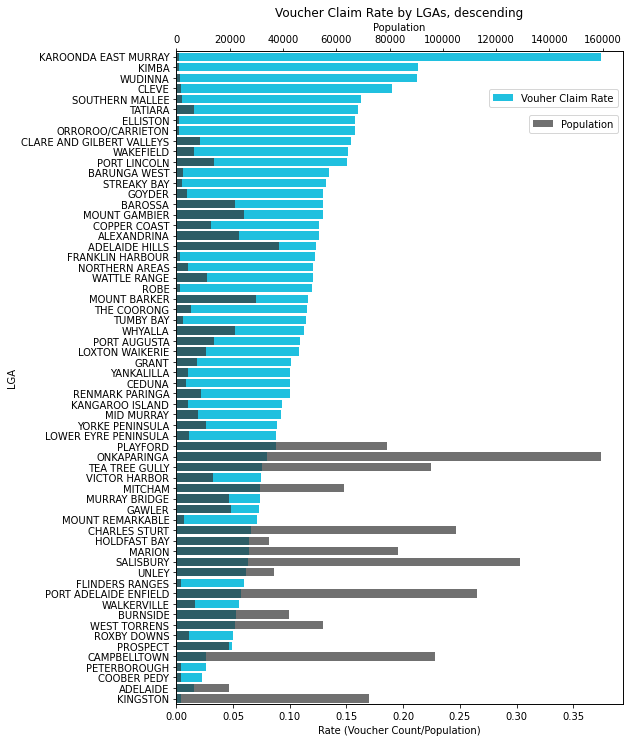

In [10]:
fig, ax = plt.subplots(figsize=(8,12))
sns.barplot(data = grouped_LGA,y=grouped_LGA.index,x='Rate',ax=ax,color='#00D5FF',label='Vouher Claim Rate')
ax2 = ax.twiny()
sns.barplot(data = grouped_LGA,y=grouped_LGA.index,x='Population',ax=ax2,color='#333333',alpha=.7,label='Population')
ax.set_title('Voucher Claim Rate by LGAs, descending')
ax.set_xlabel('Rate (Voucher Count/Population)')
ax.legend(loc='upper right',bbox_to_anchor=(0.5, 0.1, 0.5, 0.85))
ax2.legend(loc='upper right',bbox_to_anchor=(0.5, 0.1, 0.5, 0.81))
None

Seen from the graph above, Karoonda East Murry has the highest Voucher Claim Rate, but it has a fairly small population.

Meanwhile, Kingston has a fairly low voucher claim rate comparing to its population size.

It seems several of high population LGAs have pretty low voucher claim rates, while LGAs with samll population generally have high voucher claim rates.

In [11]:
# Distribution by Sport

grouped_sport = sa_vouchers_scores.groupby(['Voucher_Sport'])['ID'].count()
grouped_sport = grouped_sport.sort_values(ascending=False)
grouped_sport = grouped_sport.to_frame()
grouped_sport.reset_index(inplace=True)
grouped_sport.columns=['Sport','Count']
grouped_sport.head()

,Sport,Count
0,Australian Rules,47224
1,Netball,24017
2,Football (Soccer),15775
3,Gymnastics,9823
4,Basketball,6016


In [12]:
grouped_sport.drop(grouped_sport[(grouped_sport.Count<1000)].index,inplace=True)
grouped_sport.shape

(12, 2)

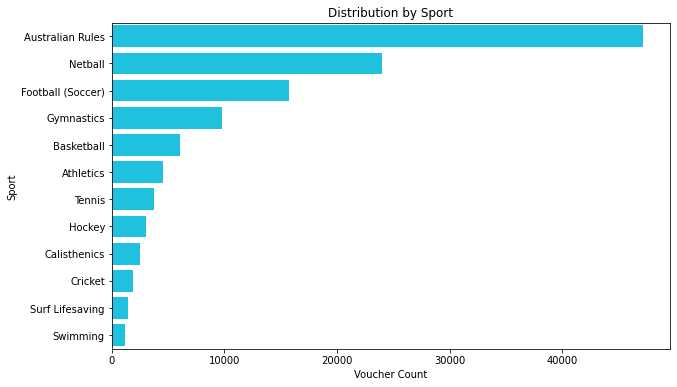

In [13]:
plt.figure(figsize=(10,6))
sns.barplot(data=grouped_sport,y='Sport',x='Count',color='#00D5FF')
plt.xlabel('Voucher Count')
plt.title('Distribution by Sport')
None

As seen from the plot above, Australian Rules Football was the most popular game. Netball, which I've never heard of before this, is the second most popular.

In [14]:
# Are some sports more popular in different parts of the state?

fav_sport = sa_vouchers_scores.groupby(["LGA", "Voucher_Sport"]).count()
fav_sport = fav_sport.sort_values(by="ID", ascending=False)
fav_sport.drop("Population", axis=1, inplace=True)
fav_sport = fav_sport.join(LGA_population, on="LGA")
fav_sport = fav_sport[["ID", "Population"]]
fav_sport.columns = ["Count", "Population"]
fav_sport["Rate"] = fav_sport.Count / fav_sport.Population
fav_sport = fav_sport.sort_values(by="Rate", ascending=False)
fav_sport.reset_index(inplace=True)
fav_sport.head()


,LGA,Voucher_Sport,Count,Population,Rate
0,KIMBA,Netball,194,1087.0,0.178473
1,KAROONDA EAST MURRAY,Australian Rules,169,1035.0,0.163285
2,WUDINNA,Netball,194,1256.0,0.154459
3,CLEVE,Australian Rules,218,1729.0,0.126084
4,ELLISTON,Australian Rules,105,1045.0,0.100478


Text(0.5, 1.0, 'LGAs and Their Favorite Sport (Sports with too small a portion were omitted)')

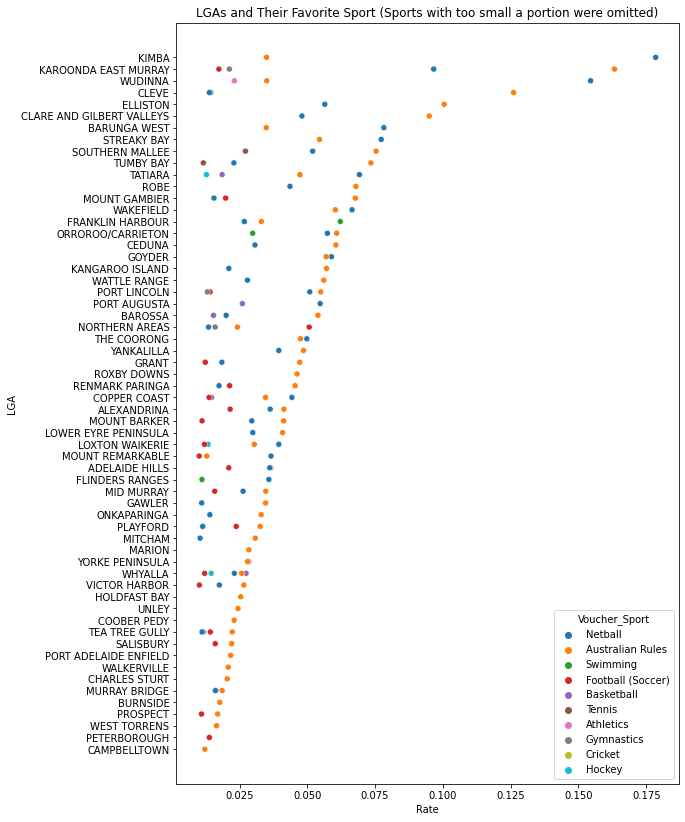

In [20]:
fav_sport.dropna(inplace=True)
fav_sport.drop(fav_sport[(fav_sport.Rate<0.01)].index, inplace=True)

plt.figure(figsize=(9,14))
sns.scatterplot(data=fav_sport,y='LGA',x='Rate',hue='Voucher_Sport')
plt.title('LGAs and Their Favorite Sport (Sports with too small a portion were omitted)')

The majority of the people living in these LGAs enjoy either Australian Rules Football or Netball. For people in Kimba and Wudina, they love Netball alot more than Footy. But for people living in Karoonda East Murray and a lot of other places, people mostly prefer footy.

Also, sometimes other sports come up on top. E.g., residents in Frenklin Harbor enjoy swimming a lot; residents in Northern Areas enjoy soccer more; residents in Whyalla prefer basketball to footy.

In [16]:
# Are any LGAs over/under represented in their use of vouchers?
# Is there a relationship between any of the SEIFA measures and voucher use in an LGA?

## Challenge - Queensland

_Note: this is an extra task that you might take on to get a better grade for your portfolio.  You can get a good pass grade without doing this._ 

Queensland has a similar program called [Get Started](https://data.gov.au/dataset/ds-qld-3118838a-d425-48fa-bfc9-bc615ddae44e/details?q=get%20started%20vouchers) and we can retrieve data from their program in a similar format.  

The file [round1-redeemed_get_started_vouchers.csv](files/round1-redeemed_get_started_vouchers.csv) contains records of the vouchers issued in Queensland. The date of this data is not included but the program started in 2015 so it is probably from around then.  

The data includes the LGA of the individual but the name of the activity is slightly different.  To do a comparable analysis you would need to map the activity names onto those from South Australia. 

In [17]:
qld_vouchers = pd.read_csv('files/round1-redeemed_get_started_vouchers.csv')
qld_vouchers.head()

,Application Number,Voucher Number,Child Age (at time of Application),Gender,Has your child played sport before?,Participation Activity,Club Name,Club Suburb/Town,Club Local Government Area Name,Club State Electoral District Name,Parent Suburb/Town,Total Payment
0,2000012253,Q89QDUXP,10,NaN,Yes,*Other,Queensland Police-Citizens Youth Welfare Assoc...,Airlie Beach,Whitsunday (R),Whitsunday,Jubilee Pocket,60.01
1,2000001727,593F6Y41,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Leichhardt,150.00
2,2000013464,PH2R4RTT,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Woodridge,150.00
3,2000009270,035SE2H5,5,NaN,Yes,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Yatala,150.00
4,2000007273,NP6C4729,6,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Alexandra Hills,150.00


In [18]:
# Join the QLD data with the LGA data as before to get population and SIEFA data integrated
qld_vouchers['LGA'] = qld_vouchers['Club Local Government Area Name'].str.replace(' \([RC]+\)', '').str.upper()
qld_vouchers_scores = qld_vouchers.join(LGA_scores, on='LGA')
qld_vouchers_scores.head()

,Application Number,Voucher Number,Child Age (at time of Application),Gender,Has your child played sport before?,Participation Activity,Club Name,Club Suburb/Town,Club Local Government Area Name,Club State Electoral District Name,Parent Suburb/Town,Total Payment,LGA,IEO,IER,IRSAD,IRSD,Population
0,2000012253,Q89QDUXP,10,NaN,Yes,*Other,Queensland Police-Citizens Youth Welfare Assoc...,Airlie Beach,Whitsunday (R),Whitsunday,Jubilee Pocket,60.01,WHITSUNDAY,989.0,989.0,966.0,982.0,31393.0
1,2000001727,593F6Y41,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Leichhardt,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0
2,2000013464,PH2R4RTT,5,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Woodridge,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0
3,2000009270,035SE2H5,5,NaN,Yes,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Yatala,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0
4,2000007273,NP6C4729,6,NaN,No,*Other,Guides Queensland,Windsor,Brisbane (C),Brisbane Central,Alexandra Hills,150.00,BRISBANE,1018.0,1018.0,1057.0,1048.0,1042074.0
